# Distributed models examples

François-David Collin (CNRS, IMAG, Paul-Valéry Montpellier 3
University)  
Wednesday, August 27, 2025

# Prerequisites

You will need to install `dask[complete]` and `graphviz` packages.

# Initialization

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)          # Fully-featured local Dask cluster
client = cluster.get_client()
client

/Users/fradav/Documents/Dev/Python/Cours-programmation-MIASHS-2025/.venv/lib/python3.13/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60931 instead


## Distributed prime numbers

Let’s revive our functions

In [3]:
import math

def check_prime(n):
    if n % 2 == 0:
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True

In [4]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [5]:
import numpy as np

def find_primes(r):
    return np.array(list(filter(check_prime,r)))

### First steps

1.  Complete with the correct Dask code the function below which:
    -   takes a maximum number `N` and a `chunksize` as arguments
    -   creates a Dask `array` with numbers from 1 to `N` split into
        `chunksize` chunks
    -   maps the `find_primes` function to each chunk
    -   returns the resulting Dask array

See [Dask Array
documentation](https://docs.dask.org/en/stable/array.html).

``` python
import dask.array as da

def calculate_primes(N,chunksize):
    arr = ...
    return arr....
```

1.  Benchmark it for

``` python
N = 5000000
```

In [6]:
import dask.array as da

def calculate_primes(N, workers):
    arr = da.arange(1, N, chunks=N // workers)
    # Apply find_primes to each chunk using map_blocks
    return arr.map_blocks(find_primes)

In [7]:
N = 5000000

In [8]:
compute_graph = calculate_primes(N,8)
compute_graph

In [9]:
%timeit compute_graph.compute()

2.36 s ± 7.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

1.  Visualize the computation graph

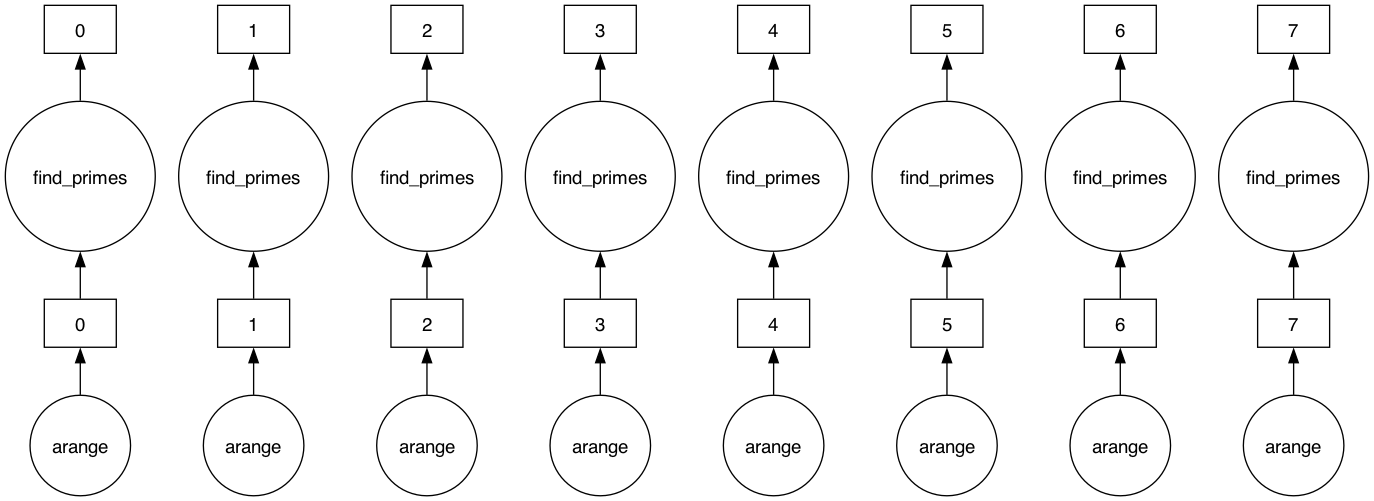

In [10]:
compute_graph.visualize()

# An embarrassingly parallel example : distributed Monte-Carlo computing of $\pi$

If we sample randomly a bunch of $N$ points in the unity square, and
counts all points $N_I$ verifying the condition

$x^2 + y^2 \le 1$ which means they are in the upper right quarter of a
disk.

We have this convergence

$\lim_{N\to\infty} 4\frac{N_I}{N} = \pi$

<img src="attachment:hpp2_0901.png" width="40%" />

### 2. Write the function which :

-   takes a number of estimates `nbr_estimates` as argument
-   samples them in the \[(0,0),(1,1)\] unity square
-   returns the number of points inside the disk quarter

``` python
def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    ...
    return nbr_trials_in_quarter_unit_circle
```

In [11]:
import random

def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    nbr_trials_in_quarter_unit_circle = 0
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle
    return nbr_trials_in_quarter_unit_circle

In [12]:
4*estimate_nbr_points_in_quarter_circle(1e4)/1e4

3.134

### 3. Make it distributed

-   Wraps the previous function in \`\`\`python import dask.bag as db

    def calculate_pi_distributed(nnodes,nbr_samples_in_total) … return
    estimated_pi \`\`\`

-   `nnodes` will use only `nnodes` partitions for bag and split the
    number of estimates for each worker nodes into `nnodes` blocks.

-   Try it on `1e8` samples and benchmark it on 1 to 8 nodes. (use
    [`time`](https://docs.python.org/3/library/time.html#time.time))

-   Plot the performance gain over one node and comment the plot.

See [Dask Bag documentation](https://docs.dask.org/en/stable/bag.html).

In [13]:
import dask.bag as db

def calculate_pi_distributed(nnodes, nbr_samples_in_total):

    nbr_samples_per_worker = int(nbr_samples_in_total // nnodes)
    samples = [nbr_samples_per_worker] * nnodes
    bag = db.from_sequence(samples, npartitions=nnodes)
    results = bag.map(estimate_nbr_points_in_quarter_circle).compute()
    return sum(results) * 4 / nbr_samples_in_total

In [14]:
calculate_pi_distributed(8,1e7)

3.1417844

In [15]:
import time

N = 1e8
cluster_times = []
pis = []
for nbr_parallel_blocks in range(1,9):
    print(f"With {nbr_parallel_blocks} node(s): ")
    t1 = time.time()
    pi_estimate = calculate_pi_distributed(nbr_parallel_blocks,N)
    total_time = time.time() - t1
    print(f"\tPi estimate : {pi_estimate}")
    print("\tTime : {:.2f}s".format(total_time))
    cluster_times.append(total_time)
    pis.append(pi_estimate)

With 1 node(s): 
    Pi estimate : 3.14191356
    Time : 14.41s
With 2 node(s): 
    Pi estimate : 3.1413418
    Time : 7.33s
With 3 node(s): 
    Pi estimate : 3.1416694
    Time : 5.09s
With 4 node(s): 
    Pi estimate : 3.14179448
    Time : 3.86s
With 5 node(s): 
    Pi estimate : 3.14174896
    Time : 3.06s
With 6 node(s): 
    Pi estimate : 3.14166004
    Time : 2.58s
With 7 node(s): 
    Pi estimate : 3.14164924
    Time : 2.30s
With 8 node(s): 
    Pi estimate : 3.14160324
    Time : 2.08s

In [16]:
import plotly.express as px

speedups_cores = [cluster_times[0]/cluster_times[i] for i in range(8)]
px.line(y=speedups_cores,x=range(1,9),
        labels={"x":"Number of cores",
                "y":"Speedup over 1 core"},
       width=600)

$\Longrightarrow$ We see a near perfect linear scalability.